# Image Segmentation

Image segmentation is a technique used to separate an image into **multiple segments or regions**, each of which corresponds to a different object or part of the image.

The goal is to simplify the image and make it easier to analyze, so that a computer can better understand and interpret the content of the image, which can be really useful!

## Different types of segmentations

There are two main types of image segmentation: semantic segmentation and instance segmentation.

* **Semantic segmentation** is the task of assigning a class label to each pixel in an image. For example, in an image of a city, the task of semantic segmentation would be to label each pixel as belonging to a certain class, such as "building", "road", "sky", ...

* **Instance segmentation** is a variation of semantic segmentation that not only assigns a class label to each pixel, but also differentiates between multiple instances of the same class within an image. For example, in an image of a city, the task would be to not only label each pixel as belonging to a certain class, such as "building", "road", ..., but also to distinguish between different instances of the same class, such as different buildings in the image. Each building will then be represented by a different color.

Of course, it is possible that not all pixels will be assigned a label. Indeed, some pixels may be part of the background or may not belong to any object of interest in the image. These pixels can be affected to a special class, or can be left without a label.

# Pipeline

Step 1: Setting up the environment

Step 2: Data Acquisition

Step 3: Data Exploration, visualization

Step 4: Data preparation for training

Step 5: Build the model

Step 6: Train the model

Step 7: Evaluation

# 1) Setting up the environment

In [ ]:
! pip install -r requirements.txt

In [ ]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
import tensorflow
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

# 2) Data Acquisition

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Resuming download from 1073741824 bytes (3394829117 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/awsaf49/brats20-dataset-training-validation?dataset_version_number=1 (1073741824/4468570941) bytes left.


100%|██████████| 4.16G/4.16G [00:27<00:00, 125MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1


In [ ]:
# Absolute path of the incorrectly named file
old_name = "brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file
try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

Maybe you have already renamed the file or the file is not misspelled on the dataset anymore


# 3) Data Exploration and visualization

This dataset contains magnetic resonance imaging (MRI) scans of brain tumors.

To be more specific, each patient of this dataset is represented through four different MRI scans / modalities, named T1, T1CE, T2 and FLAIR. These 4 images come with the ground truth segmentation of the tumoral and non-tumoral regions of their brains, which has been manually realized by experts.



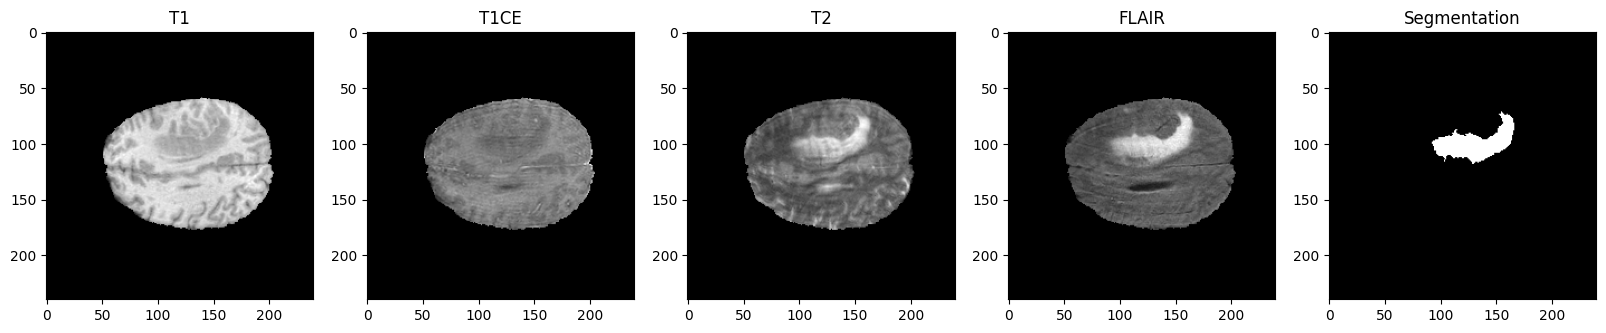

In [ ]:
# Specify a sample path (here we will take the first patient of the Training dataset)
sample_path = os.path.join(path, 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_')

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')

plt.savefig('sample0_slice100_4_modularities.png')
plt.show()

## Modalities

Why 4 modalities ?

As you can see, the four modalities bring out different aspects for the same patient. To be more specific, here is a description of their interest:

* T1 : Show the structure and composition of different types of tissue.
* T1CE: Similar to T1 images but with the injection of a contrast agent, which will enhance the visibility of abnormalities.
* T2: Show the fluid content of different types of tissue.
* FLAIR: Used to suppress this fluid content, to better identify lesions and tumors that are not clearly visible on T1 or T2 images.
For an expert, it can be useful to have these 4 modalities in order to analyze the tumor more precisely, and to confirm its presence or not.

But for our artificial approach, using only two modalities instead of four is interesting since it can reduce the amount of manipulated data and therefore the computational and memory requirements of the segmentation task, making it faster and more efficient.

That is why we will exclude T1, since we have its improved version T1CE. Also, we will exclude the T2 modality. Indeed, the fluids it presents could degrade our predictions. These fluids are removed in the flair version, which highlights the affected regions much better, and will therefore be much more interesting for our training.

## Images format

You may have noticed that these images are in .nii format. Indeed, these scans are NIfTI files (Neuroimaging Informatics Technology Initiative). A NIfTI image is a digital representation of a 3D object, such as a brain in our case. To understand this more closely, let's display the shape of a modality scan and of a segmentation (they all have the same in this dataset):

In [ ]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


## Three plane views

As you can see, modalities & segmentations do have 3 dimensions. Each dimension is composed of a series of two-dimensional images, known as slices, which all contain the same number of pixels, and are stacked together to create this 3D representation. That is why we have displayed 2D images just above (you may not have noticed but we have displayed the 100th slice of a certain dimension, by setting the slice_nb = 100).

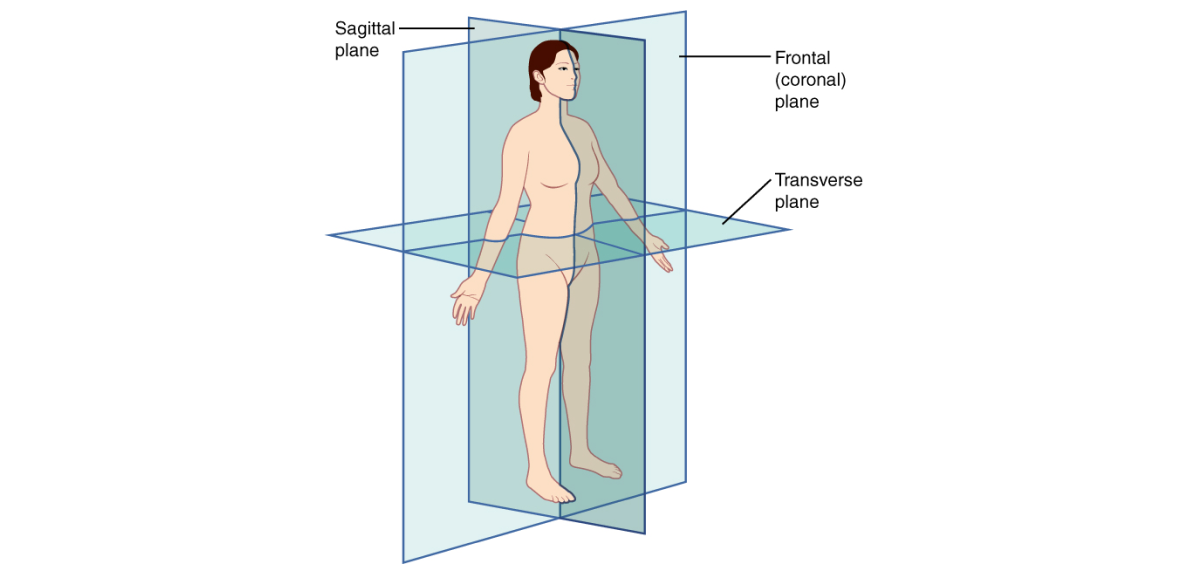

* Sagittal Plane: It divides the body into left and right sections and is often referred to as a "front-back" plane.

* Coronal Plane: It divides the body into front and back sections and is often referred to as a "side-side" plane.

* Axial or Transverse Plane: It divides the body into top and bottom sections and is often referred to as a "head-toe" plane.

So of course we can display each modality through its different planes. For example, we will display the 3 planes of the T1 image:

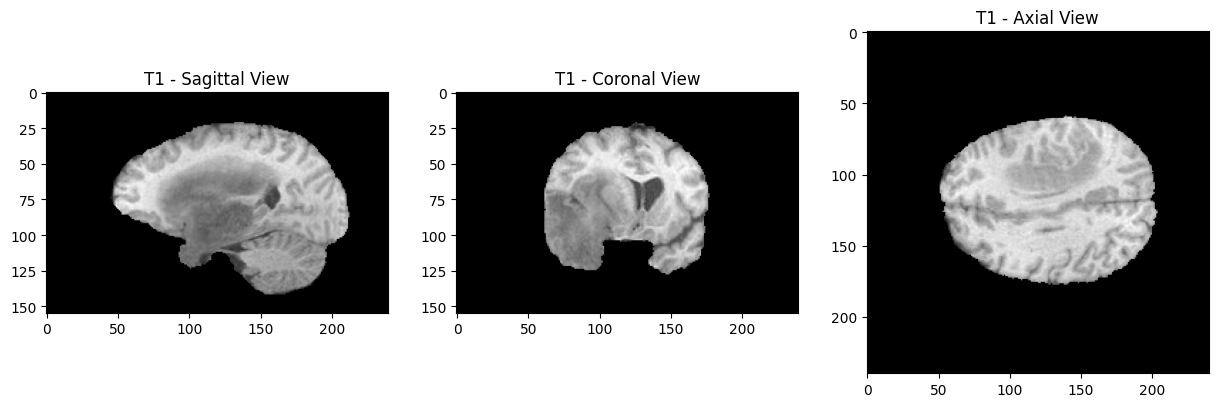

In [ ]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(15,15))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.savefig('t1_planes.png')
plt.show()

## Slices

Now that we know why we have three dimensions, let's try to understand why we chose to display a specific slice, by fixing the slice_nb to 100.

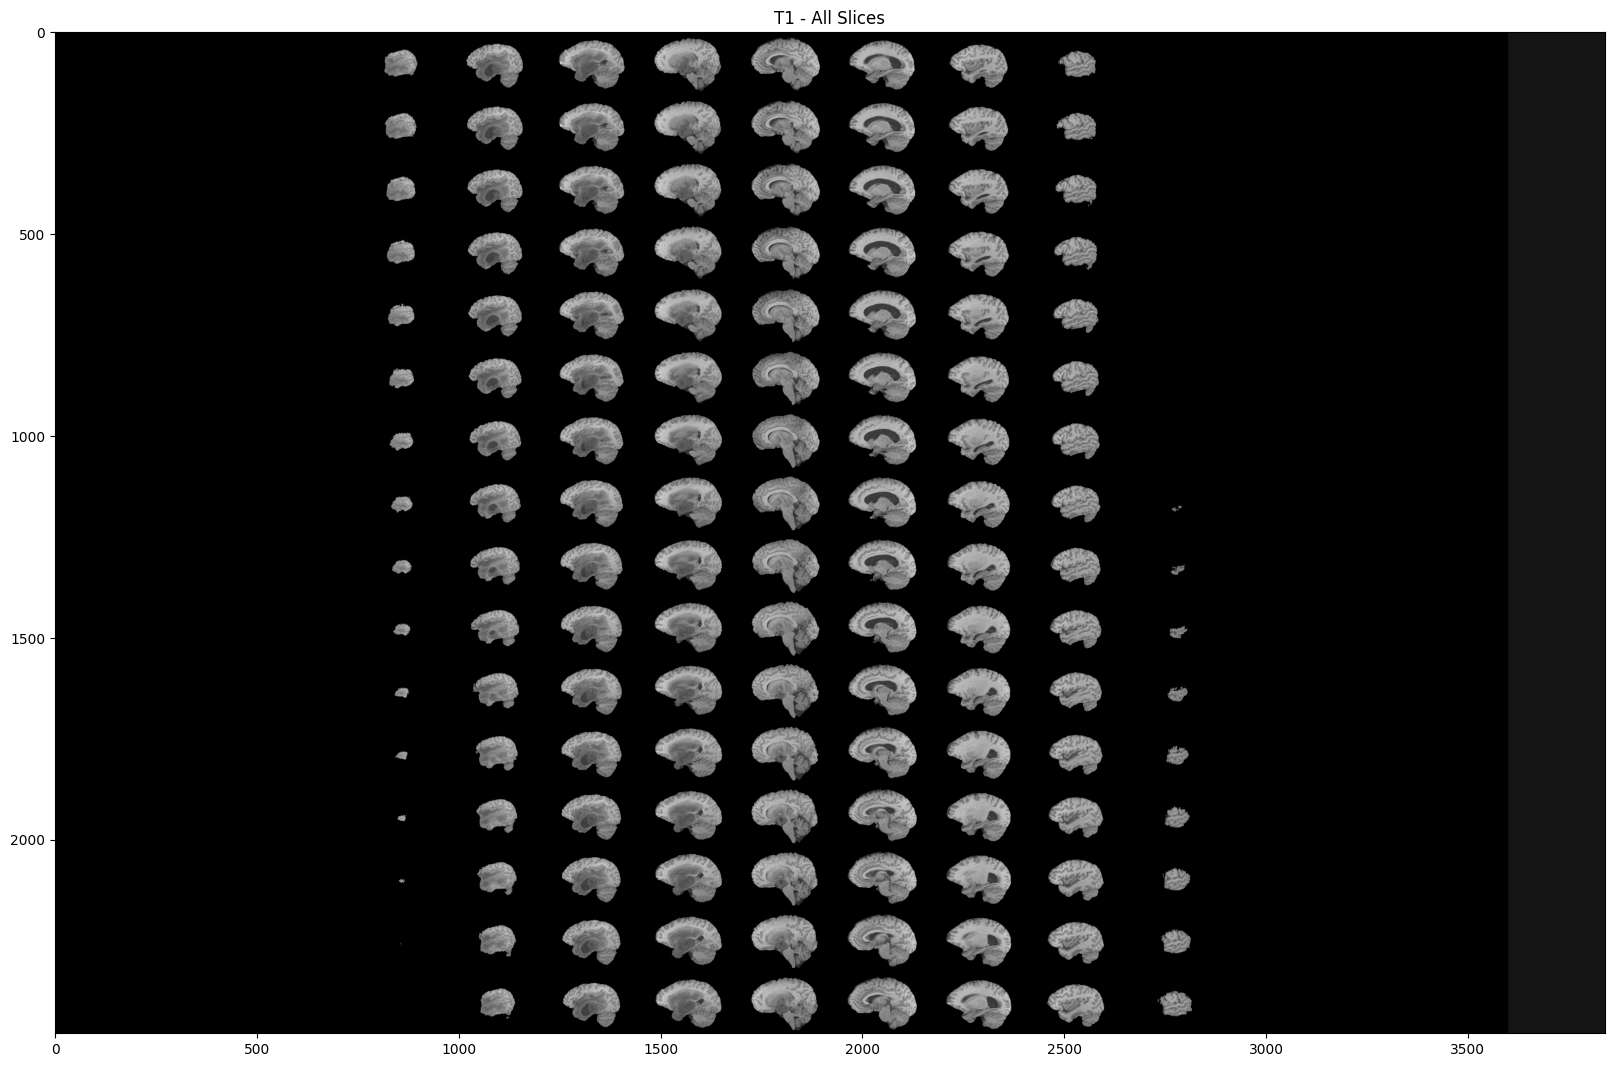

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')
plt.title('T1 - All Slices')
plt.savefig('t1_all_slices.png')
plt.show()

As you can see, two black parts are present on each side of our montage. However, these black parts correspond to the first and last slices of a plane. This means that a large part of the slices does not contain much information. This is not surprising since the slices progressively represent the brain.

You will notice that this analysis is the same on all other modalities, all planes and also on the images segmented by the experts. Indeed, they were not able to segment the slices that do not contain much information.

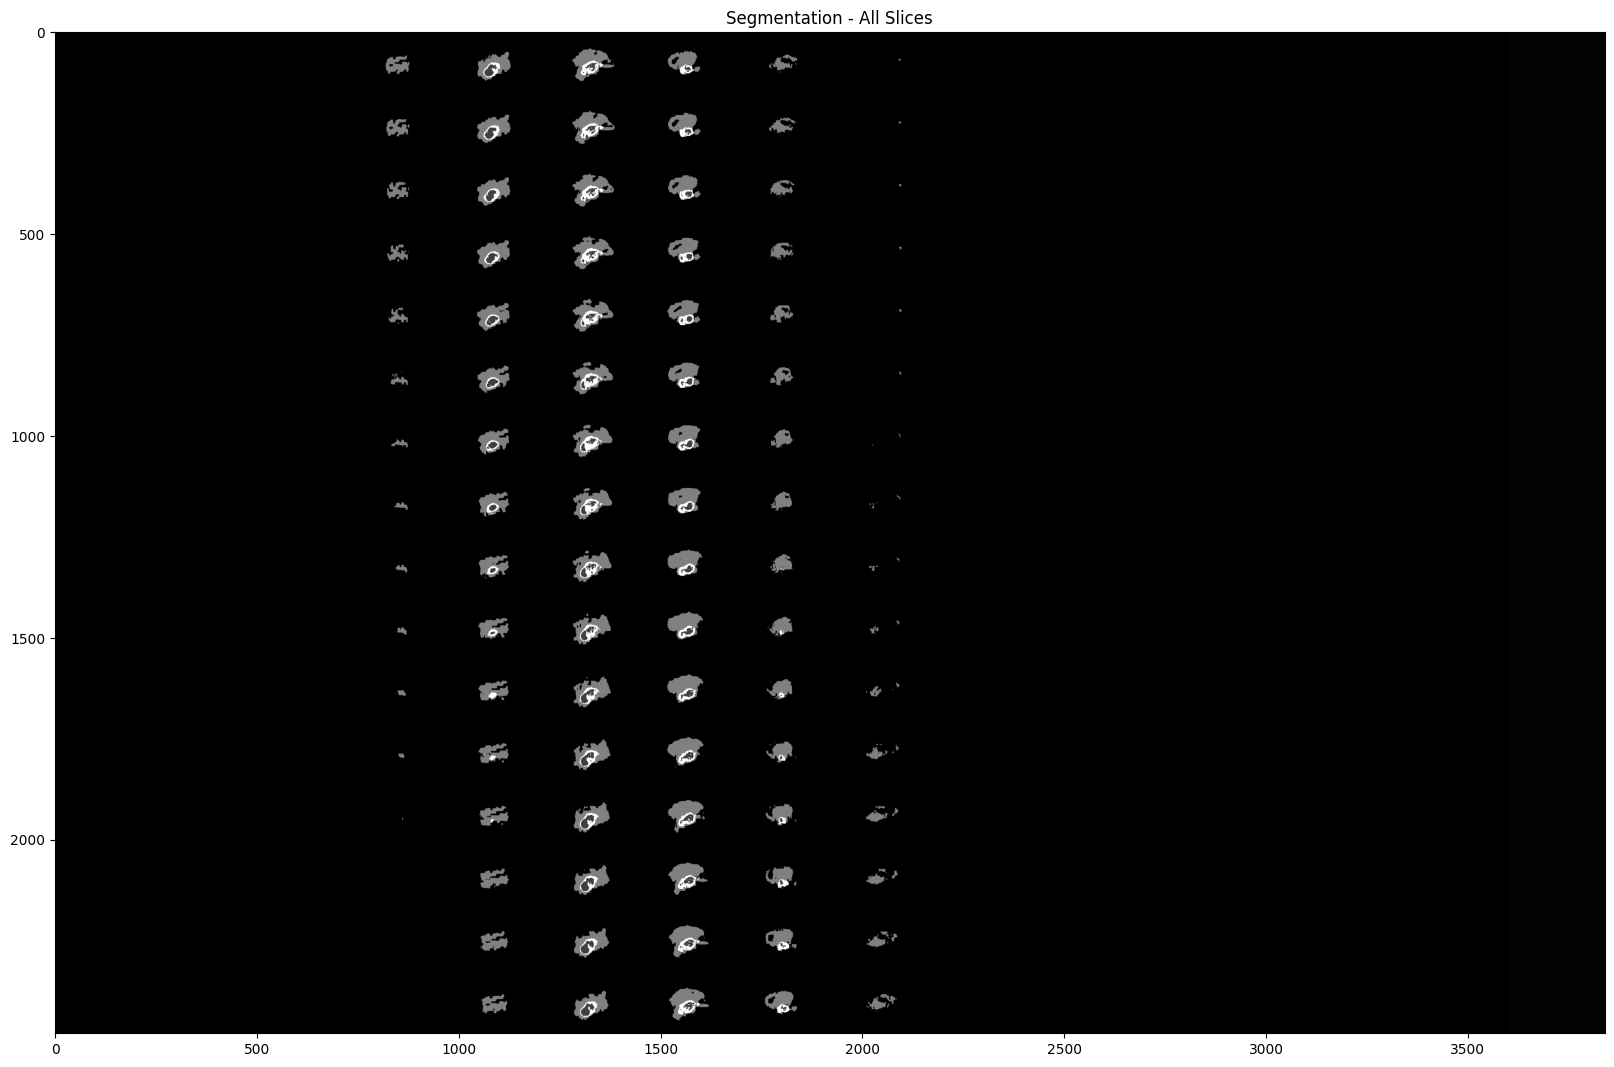

In [ ]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')
plt.title('Segmentation - All Slices')
plt.savefig('seg_all_slices.png')

This is why we can exclude these slices in our analysis, in order to reduce the number of manipulated images. Indeed, you can see that a **(60:135) range will be much more interesting**

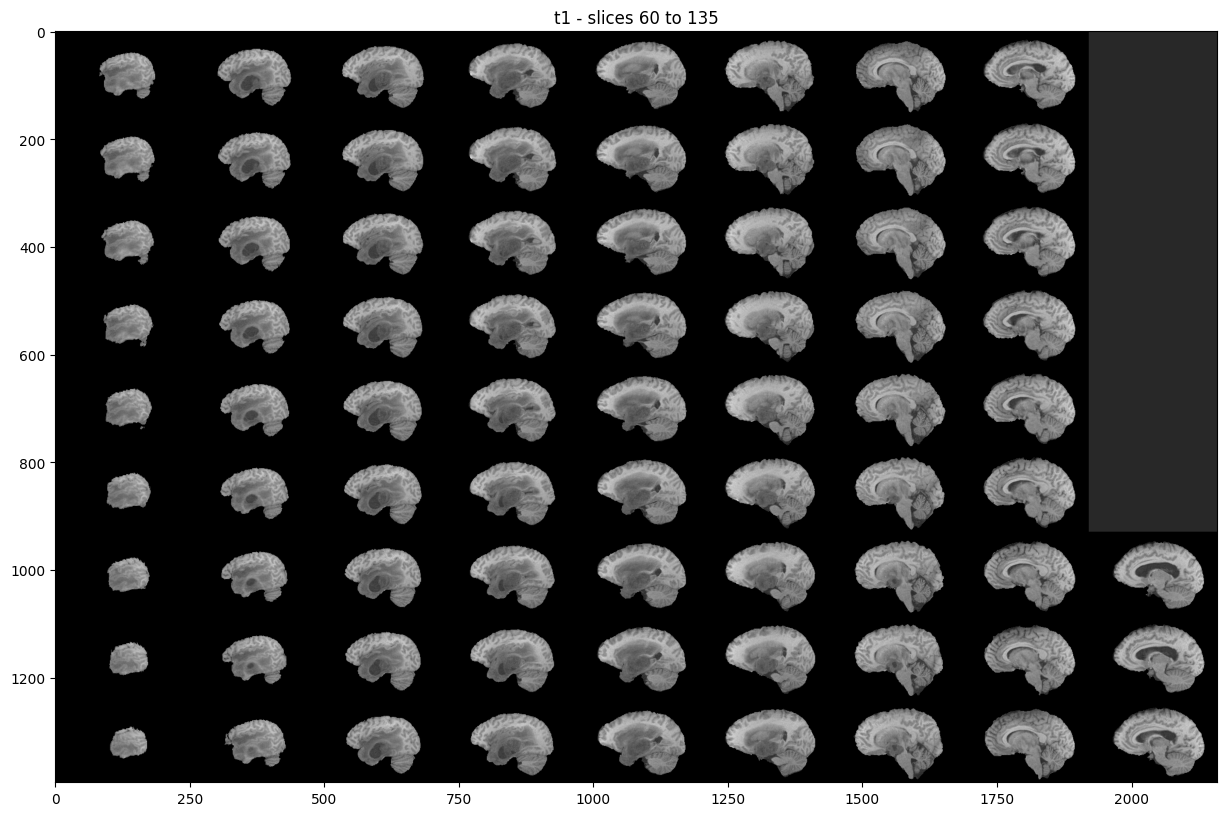

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')
plt.title('t1 - slices 60 to 135')
plt.savefig('t1_60_135.png')
plt.show()

## Segmentations

Now, let's focus on the **segmentations** provided by the experts. What information do they give us?

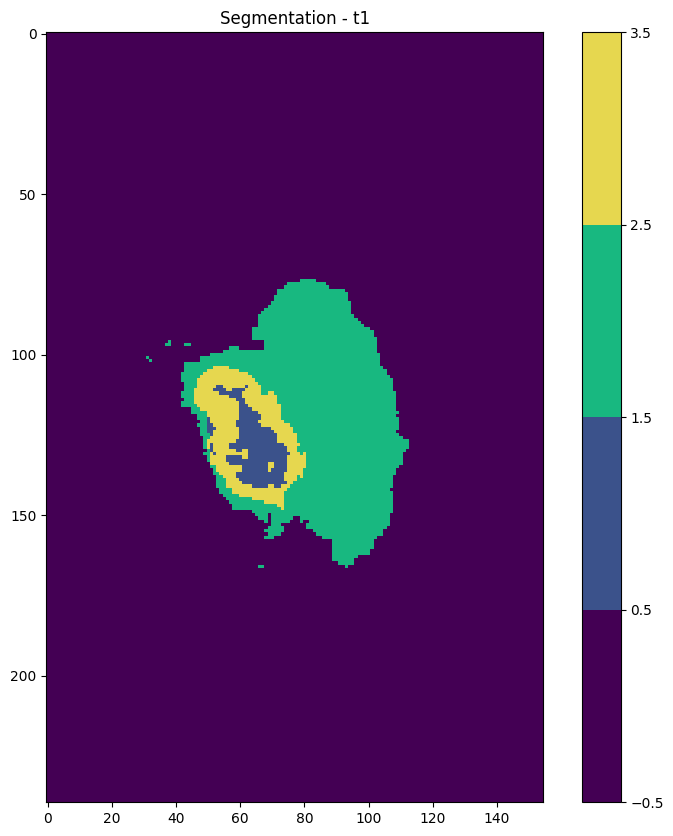

In [ ]:
# Plot a segmantation
sample_path = os.path.join(path, 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii')

some_seg_img = nib.load(sample_path).get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)
plt.figure(figsize = (10, 10))
plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()
plt.title('Segmentation - t1')
plt.savefig('seg_t1.png')
plt.show()

## Different possible values in segmentations

Regardless of the plane you are viewing, you will notice that some slices have multiple colors (here 4 colors), which means that the experts have assigned multiple values to the segmentation. Let's see what values are possible in this dataset

In [ ]:
data_path = os.path.join(path, 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/')
# Corrected list comprehension: remove the unnecessary f"{sample}_seg.nii" and just use 'sample' directly
seg_samples = [os.path.join(data_path, sample) for sample in os.listdir(data_path) if sample.endswith('_seg.nii')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


We notice that we have 4 possible values in the segmentation files. These 4 values will form our 4 classes. Here is what they correspond to:

* 0 : Not Tumor (NT) which means Healthy Zone or Background
* 1 : Necrotic and Non-Enhancing Tumor (NCR + NET)
* 2 : Peritumoral Edema (ED)
* 4 : Enhancing Tumor (ET)
As you can see, class 3 does not exist. We go directly to 4. We will therefore modify this “error” before sending the data to our model.

Our goal is to predict and segment each of these 4 classes for new patients to find out whether or not they have a brain tumor and which areas are affected.

Let's now take a look at the distribution of these 4 values:

In [ ]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


We see that the previous segmentation has a lot of annotated data fixed to 0, which corresponds to the background (useless information). We might consider cropping our images to eliminate some of this useless area, to reduce the complexity of the segmentation task and thus speed up our training by reducing processing time.

Let's see what these 4 different classes correspond to, by displaying the classes one by one:

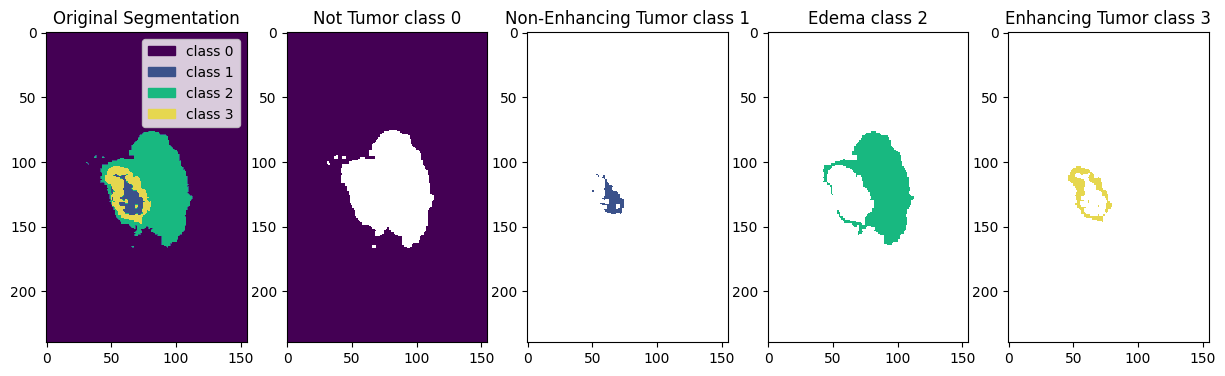

In [ ]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.savefig('Tumor_classes.png')
plt.show()

To summarize data exploration:

* We have for each sample / patient **4 different modalities (T1, T1CE, T2 & FLAIR)**, accompanied by a segmentation that indicates tumor areas.

* Modalities **T1CE and FLAIR** are the more interesting to keep, since these 2 provide complementary information about the anatomy and tissue contrast of the patient’s brain.

* Each image is 3D, and can therefore be analyzed through 3 different planes that are composed of 2D slices.

* Many slices contain little or no information. We will only keep the **(60:135)** slices interval for this tutorial. Of course, you are free to customize the code to send less or more slices to your model, but the training time will be longer.

* A segmentation image contains 1 to 4 classes.

* Class number 4 must be reassigned to 3 since value 3 is missing.

* Class 0 (background) is over-represented in the majority of the scans. However, cropping can remove important information. We will not use it in this tutorial and will keep the images as they are.

Now that we know more about our data, it is time to prepare the training of our model.

In [ ]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

# 4) Data Preparation

First, let's retrieve all samples that are present in the Training folder:

In [ ]:
data_path = os.path.join(path, 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/')
samples = os.listdir(data_path)
len(samples)

371

We obtain **371** files while the braTS dataset contains only **369 samples**. The reason is simple: 2 .csv files are present in the MICCAI_BraTS2020_TrainingData directory, indicated by the data_path variable, and have therefore been added to our samples list. So we are going to remove them:

In [ ]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

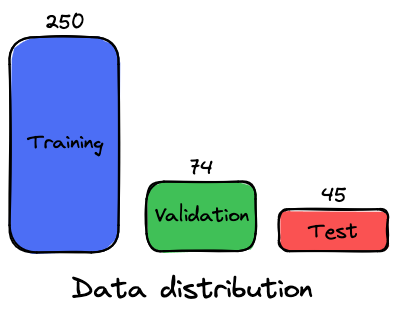

## Split the data

In [ ]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


## Data Generator

In order to train a neural network to segment objects in images, it is necessary to feed it with both the raw image data (X) and the ground truth segmentations (y). By combining these two types of data, the neural network can learn to recognize tumor patterns and make accurate predictions about the contents of a patient’s scan.

Unfortunately, our modalities images (X) and our segmentations (y) cannot be sent directly to the AI model. Indeed, loading all these 3D images would overload the memory of our environment and cause the system to crash. This will also lead to shape mismatch errors. We have to do some image preprocessing before, which will be done by using a Data Generator, where we will perform any operation that we think is necessary when loading the images.

More specifically, we will, for each sample:

* Retrieve the paths of its modalities (T1CE & FLAIR, since these 2 provide complementary information about the anatomy and tissue contrast of the brain)

* Retrieve the path of the Ground truth (original segmentation)

* Load modalities & segmentation

* Create a X array that will contain all the selected slices (60-135) of these 2 modalities.

* Create an y array that will contain all the selected slices of the segmentation.

* Assign to all the 4 in the mask array the value 3 (in order to correct the 3 missing case explained previously).

In addition to these preprocessing steps, we will:

* **Work in the Axial plane:** Since the images are square in shape (240x240) in this plane. But since we will manipulate a range of slices, we will be able to visualize the predictions in the 3 planes, so it doesn't really have an impact.

* **Apply a One-Hot Encoder to the y array:** Since our goal is to segment regions that are represented as different classes (0 to 3), we must use One-Hot Encoding to convert our categorical variables (classes) into a numerical representation that can be used by our neural network (since they are based on mathematical equations). Indeed, from a mathematical point of view, sending the y array as it is would mean that some classes are superior to others, while there is no superiority link between them. For example, class 1 is inferior to class 4 since 1 < 4. A One-Hot encoder will allow us to manipulate only 0 and 1. Here is what it consists of, for one slice:

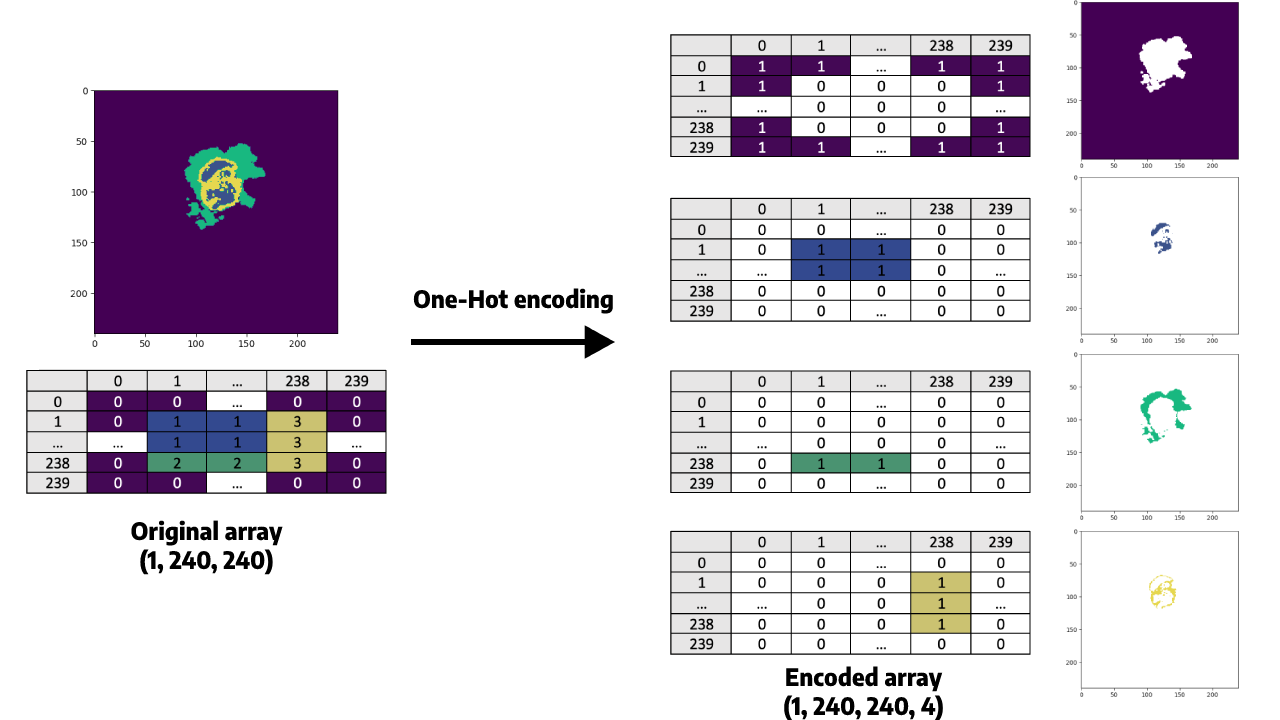

* **Resize each slice of our images from (240x240) to a (128, 128) shape:** Resizing slices from (240x240) to (128x128) is needed since we need image shapes that are a power of two (2n, where n is an integer). This is due to the fact that we will use pooling layers (MaxPooling2D) in our convolutional neural network (CNN), which reduce the spatial resolution by 2.
You may wonder why we didn't resize the images in a (256, 256) shape, which also is a power of 2 and is closer to 240 than 128 is.

This choice depends on several factors, such as the complexity of the model, the amount of training data, the computational resources available, and the desired balance between computational efficiency and information preservation.

Indeed, resizing images to (256, 256) may preserve more information than resizing to (128, 128), which could lead to better performance. However, this larger size also means that the model will have more parameters, which can increase the training time and memory requirements, which is the reason why we will choose the (128, 128) shape.

In [ ]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 128

class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):

            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'

            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/'

# Check if the incorrect filename exists
incorrect_filename = 'W39_1998.09.19_Segm.nii'
incorrect_filepath = os.path.join(dataset_path, incorrect_filename)

if os.path.exists(incorrect_filepath):
    # Construct the correct filename
    correct_filename = 'BraTS20_Training_355_seg.nii'
    correct_filepath = os.path.join(dataset_path, correct_filename)

    # Rename the file
    os.rename(incorrect_filepath, correct_filepath)
    print(f"Renamed '{incorrect_filename}' to '{correct_filename}'")
else:
    print(f"File '{incorrect_filename}' not found. Skipping rename.")


Renamed 'W39_1998.09.19_Segm.nii' to 'BraTS20_Training_355_seg.nii'


To summarize the preprocessing steps:

* We use a data generator to be able to process and send our data to our neural network (since all our images cannot be stored in memory at once).
* For each epoch (single pass of the entire training dataset through a neural network), the model will receive 250 samples (those contained in our training dataset).
* For each sample, the model will have to analyze 150 slices (since there are two modalities, and 75 selected slices for both of them), received in a (128, 128) shape, as an X array of a (128, 128, 75, 2) shape. This array will be provided with the ground truth segmentation of the patient, which will be One-Hot encoded and will then have a (75, 128, 128, 4) shape.

# 5) Build the model

## U-Net Architecture

We will use the U-Net architecture. This CNN is designed for biomedical image segmentation, and is particularly well-suited for segmentation tasks where the regions of interest are small and have complex shapes (such as tumors in MRI scans).

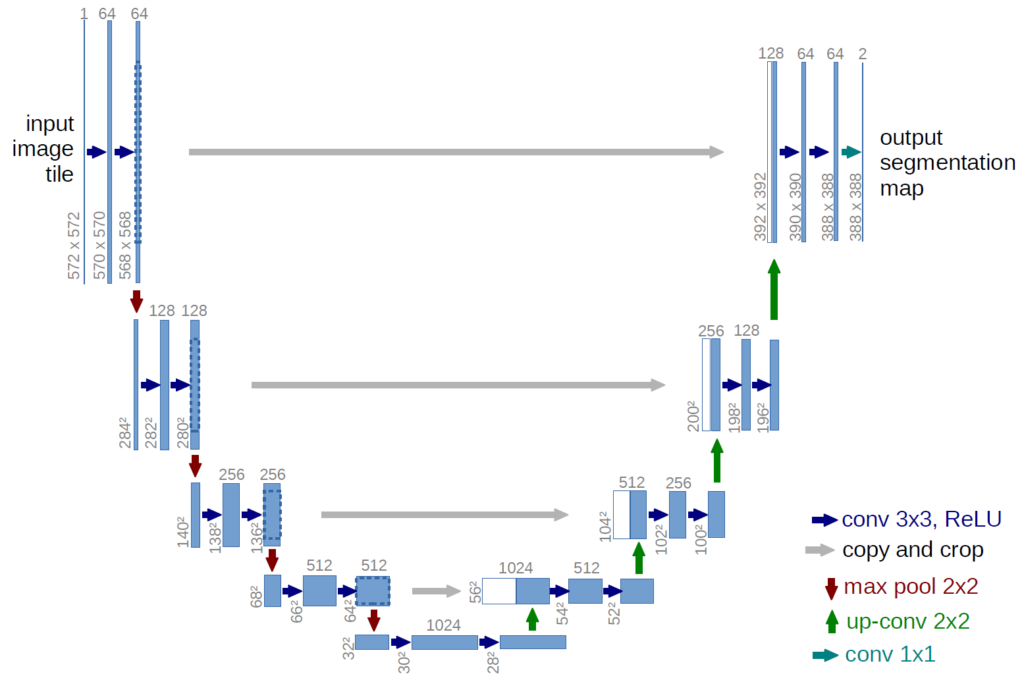

Since the BraTS2020 dataset consists of 3D images, where each consists of multiple 2D slices in three orthogonal planes, we have 2 possibilities. We can either use a 2D U-Net, or a 3D U-Net.

In theory, a 3D U-Net is more adapted in our case. Indeed, a 3D U-Net can leverage the 3D spatial context of the images, which means it can reduce the risk of false positives and false negatives that can occur due to partial or incomplete information in individual 2D slices.

However, a 2D U-Net is faster and requires less memory than a 3D U-Net, which can be an advantage when working with large datasets or limited computational resources.

In practice, it is often useful to try both 2D and 3D U-Net architectures and compare their performance on the specific segmentation task.

In [ ]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

## Loss Function

When training a CNN, it's important to choose a loss function that accurately reflects the performance of the network. Indeed, this function will allow to compare the predicted pixels to those of the ground truth for each patient. At each epoch, the goal is to update the weights of our model in a way that minimizes this loss function, and therefore improves the accuracy of its predictions.

A commonly used loss function for multi-class classification problems is **categorical cross-entropy**, which measures the difference between the predicted probability distribution of each pixel and the real value of the one-hot encoded ground truth. Note that segmentations models sometimes use the **dice loss** function as well.

## Activation Function

To get this probability distribution over the different classes for each pixel, we apply a **softmax activation function** to the output layer of our neural network.

This means that during training, our CNN will adjust its weights to minimize our loss function, which compares predicted probabilities given by the softmax function with those of the ground truth segmentation.

## Other Metrics

It is also important to monitor the model's performance using evaluation metrics.

We will of course use **accuracy**, which is a very popular measure. However, this metric can be misleading when working with imbalanced datasets like BraTS2020, where Background class is over represented. To address this issue, we will use other metrics such as the **intersection over union (IoU), the Dice coefficient, precision, sensitivity, and specificity**.

* Accuracy: Measures the overall proportion of correctly classified pixels, including both positive and negative pixels.

* IoU: Measures the overlap between the predicted and ground truth segmentations.

* Sensitivity (recall or true positive rate): Measures the proportion of positive ground truth pixels that were correctly predicted as positive.

* Precision (positive predictive value): Measures the proportion of predicted positive pixels that are actually positive.

* Specificity (true negative rate): Measures the proportion of negative ground truth pixels that were correctly predicted as negative.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

## Model

In [ ]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity])

## Callbacks

Callbacks are functions that can be executed during the training process.

We will use three callbacks:

* **ReduceLROnPlateau:** This callback reduces the learning rate when a metric has stopped improving (validation loss here). The learning rate is reduced by a factor of 0.2, the patience is set to 2 epochs, and the minimum learning rate is set to 0.000001.

* **ModelCheckpoint:** Saves the best model weights (model that has obtained the lowest validation loss during the different epochs). Saving a model allows us to reuse it later or to share it, without having to retrain it from scratch. This will save us time and resources!

* **CSVLogger:** Add metrics to a CSV file, which is named training.log (parameter append is set to False so the file is overwritten if it already exists).

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

# 6) Model Training

In [ ]:
model.fit(training_generator,
          epochs=10,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9804 - mean_io_u: 0.4968 - dice_coef: 0.3016 - precision: 0.9830 - sensitivity: 0.9770 - specificity: 0.9943
Epoch 1: val_loss improved from 0.07257 to 0.06781, saving model to model_.01-0.067811.m5
250/250 [==============================] - 1329s 5s/step - loss: 0.0729 - accuracy: 0.9804 - mean_io_u: 0.4968 - dice_coef: 0.3016 - precision: 0.9830 - sensitivity: 0.9770 - specificity: 0.9943 - val_loss: 0.0678 - val_accuracy: 0.9815 - val_mean_io_u: 0.7058 - val_dice_coef: 0.3084 - val_precision: 0.9861 - val_sensitivity: 0.9782 - val_specificity: 0.9953 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9806 - mean_io_u: 0.6830 - dice_coef: 0.3042 - precision: 0.9834 - sensitivity: 0.9775 - specificity: 0.9944
Epoch 2: val_loss improved from 0.06781 to 0.06421, saving model to model_.02-0.064206.m5
250/250 [==============================] - 132

# 7) Evaluation

In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/'
for filename in os.listdir(dataset_path):
    print(filename)

BraTS20_Training_355_t1.nii
BraTS20_Training_355_t1ce.nii
BraTS20_Training_355_t2.nii
BraTS20_Training_355_seg.nii
BraTS20_Training_355_flair.nii


In [ ]:
!ls /root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii

/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii


In [ ]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

axs[3].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
axs[3].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Mean IOU')
axs[3].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.savefig('Model_results.png')
plt.show()

# 8) Prediction

Now that our model is trained, it's time to use it to predict the segmentations in our test dataset!

In general, we have two major possibilities:

* Use the best model's weights (from epoch 26)
* Use the final model's weights

Indeed, using the final model's weights does not necessarily mean that we will get the best performances, predictions on new, unseen data.

In our case, there is no real difference between the two options, so the choice doesn't really matter.

But for another case, you may be interested in a specific version of your model. You can load it with the following code:

In [ ]:
# Compile a model and load our saved weights
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

best_saved_model.load_weights('model_.26-0.025329.m5')

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.savefig('Prediction_results.png')

    plt.show()

In [ ]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

In [ ]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

In [ ]:
!zip -r results.zip *.png *.m5 *.lag